# IFN646 - Biomedical Data Science &#151; Wearables Project

## Import of necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from preprocess import load_data, inform, __handle_missing_values
import warnings
warnings.filterwarnings('ignore')

## Load the data

In [2]:
full, train, test = load_data()

Loading cached files.


## Print statistics of the datasets

In [3]:
print("Full data:")
inform(full)
print("Training data:")
inform(train)
print("Test data:")
inform(test)

Full data:
Shape of data: (49100, 5)
There are 90.74% 0 values in column 'Actiware classification'.
There are 92.14 0 values in column 'Actiwatch activity counts'.
Training data:
Shape of data: (40761, 5)
There are 91.03% 0 values in column 'Actiware classification'.
There are 92.13 0 values in column 'Actiwatch activity counts'.
Test data:
Shape of data: (8339, 5)
There are 89.29% 0 values in column 'Actiware classification'.
There are 92.18 0 values in column 'Actiwatch activity counts'.


## Gain overview of data

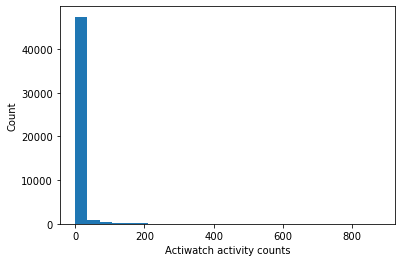

In [4]:
# plot histogram of Actiwatch activity counts for the whole data set
plt.hist(full['Actiwatch activity counts'], bins=25)
plt.ylabel('Count')
plt.xlabel('Actiwatch activity counts');

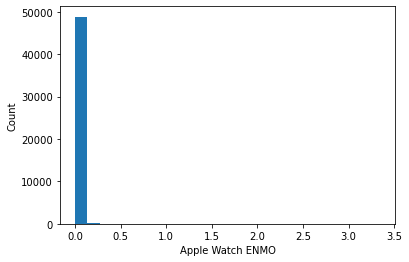

In [5]:
# plot histogram of Apple Watch ENMO for the whole data set
plt.hist(full['Apple Watch ENMO'], bins=25)
plt.ylabel('Count')
plt.xlabel('Apple Watch ENMO');

## Function to calculate total counts according to Philips’ Actiware software specification

In [6]:
def total_counts(df, src_col, dest_col):
    day = df['day'].values
    cts = df[src_col].values    
    total = []
    for i in range(len(cts)):
        div_by_25_sum = 0
        div_by_5_sum = 0
        for j in range(-8, -4):
            if i + j >= 0 and day[i + j] == day[i]:
                div_by_25_sum += cts[i + j]
        for j in range(-4, 0):
            if i + j >= 0 and day[i + j] == day[i]:
                div_by_5_sum += cts[i + j]
        for j in range(1, 5):
            if i + j < len(cts) and day[i + j] == day[i]:
                div_by_5_sum += cts[i + j]
        for j in range(5, 9):
            if i + j < len(cts) and day[i + j] == day[i]:
                div_by_25_sum += cts[i + j]
        calculation = 0.04 * div_by_25_sum + 0.20 * div_by_5_sum + 4.00 * cts[i]
        total.append(calculation)
    df[dest_col] = total

In [7]:
# call total_counts function and add a column for total counts from Actiwatch
total_counts(train, 'Actiwatch activity counts', 'Actiwatch Total Counts')

# print first 30 items
train.head(30)

,day,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,time,Actiwatch Total Counts
1,1,109.0,1.0,0.227648,20:58:15,555.20
2,1,170.0,1.0,0.217089,20:58:30,812.40
3,1,91.0,1.0,0.267528,20:58:45,548.68
4,1,101.0,1.0,0.222397,20:59:00,607.12
5,1,125.0,1.0,0.262205,20:59:15,727.64
6,1,105.0,1.0,0.283417,20:59:30,673.96
7,1,176.0,1.0,0.314253,20:59:45,954.84
8,1,105.0,1.0,0.328872,21:00:00,689.72
9,1,159.0,1.0,0.444264,21:00:15,897.32
10,1,215.0,1.0,0.521921,21:00:30,1110.12


## Helper functions that classifies into sleep/wake according to threshold 40

In [8]:
def classify(row, col):
    if row[col] > 40:
        return 1
    else:
        return 0

# Plausibility Check

## Perform classification of actiwatch total counts for plausibility check

In [9]:
train['Actiware classification calculated'] = train.apply(lambda x: classify(x, 'Actiwatch Total Counts'), axis=1)

# set uninterrupted sleep values
train = __handle_missing_values(train, 'Actiware classification calculated')

#print first 30 elements
train.head(30)


    0 rows were dropped where both activity counts and classification were missing.
    That is roughly 0.00% of the dataset.

    1125 classifications were set to 1 for the first and last 5 minutes of uninterrupted sleep.
    That is roughly 2.76% of the dataset.


,day,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,time,Actiwatch Total Counts,Actiware classification calculated
1,1,109.0,1.0,0.227648,20:58:15,555.20,1
2,1,170.0,1.0,0.217089,20:58:30,812.40,1
3,1,91.0,1.0,0.267528,20:58:45,548.68,1
4,1,101.0,1.0,0.222397,20:59:00,607.12,1
5,1,125.0,1.0,0.262205,20:59:15,727.64,1
6,1,105.0,1.0,0.283417,20:59:30,673.96,1
7,1,176.0,1.0,0.314253,20:59:45,954.84,1
8,1,105.0,1.0,0.328872,21:00:00,689.72,1
9,1,159.0,1.0,0.444264,21:00:15,897.32,1
10,1,215.0,1.0,0.521921,21:00:30,1110.12,1


## Compare classification to calculated classification

In [10]:
classification_stats = train.groupby(["Actiware classification", "Actiware classification calculated"]).size()
print(classification_stats)

Actiware classification  Actiware classification calculated
0.0                      0                                     37106
1.0                      0                                        19
                         1                                      3632
dtype: int64


The plausibility check in which we re-classified the sleep/wake state according to Philip's software specification almost yielded a perfect result. Merely 19 values are misclassified. This might be due to some NA values handled improperly or a bug in the uninterrupted sleep algorithm. We will investigate that further in the next iteration.

# Fit Machine Learning Model

## Draw scatter plot from Apple Watch and Actiwatch

<AxesSubplot:xlabel='Apple Watch ENMO', ylabel='Actiwatch activity counts'>

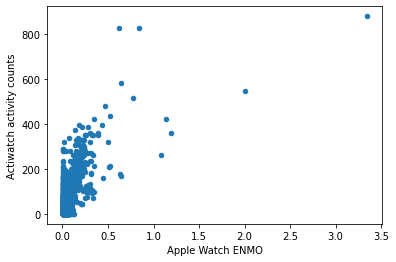

In [11]:
train.plot.scatter(x='Apple Watch ENMO', y='Actiwatch activity counts')

## Fit linear Regression Model

The function of the regression line is:
f(x) = 582.3 x + 0.2081


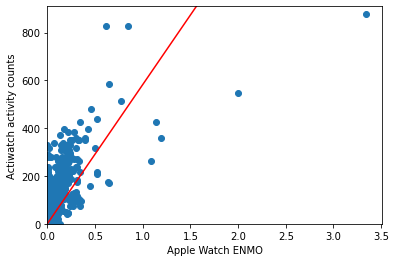

In [12]:
# declare x and y for the model
x = train['Apple Watch ENMO']
y = train['Actiwatch activity counts']

x.fillna(0, inplace=True)

# fit linear model
model = numpy.poly1d(numpy.polyfit(x, y, 1))

# create linspace to draw scatter plot in next step
line = numpy.linspace(0, 3.5, 1000)

# scatter plot
plt.scatter(x, y)

# draw regression graph into plot
plt.plot(line, model(line), color='red')

# set limits
plt.xlim([0,3.51])
plt.ylim([0,910])

# set labels
plt.xlabel("Apple Watch ENMO")
plt.ylabel("Actiwatch activity counts")

print('The function of the regression line is:\nf(x) =', str(model).strip())

## Predict if sleep or awake for test data

In [13]:
# predict activity counts
test['Predicted activity counts'] = model(test['Apple Watch ENMO'])

# calculate total counts from prediction
total_counts(test, 'Predicted activity counts', 'Predicted Total Counts')

# print first 15 rows
test.head(15)

,day,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,time,Predicted activity counts,Predicted Total Counts
7789,5,91.0,1.0,0.049485,22:11:15,29.023007,317.353564
7790,5,62.0,1.0,0.047339,22:11:30,27.773589,323.652867
7791,5,58.0,1.0,0.069403,22:11:45,40.621203,379.619787
7792,5,154.0,1.0,1.066049,22:12:00,620.965014,2585.415302
7793,5,164.0,1.0,0.503060,22:12:15,293.138021,1340.419208
7794,5,159.0,1.0,0.117267,22:12:30,68.492317,482.563578
7795,5,94.0,1.0,0.075325,22:12:45,44.069387,385.774107
7796,5,0.0,1.0,0.003893,22:13:00,2.474936,221.692133
7797,5,6.0,1.0,0.006534,22:13:15,4.012591,128.706828
7798,5,0.0,1.0,0.003435,22:13:30,2.208075,74.220209


In [14]:
# classify
test['Predicted wake'] = test.apply(lambda x: classify(x, 'Predicted Total Counts'), axis=1)

# set uninterrupted sleep values
test = __handle_missing_values(test, 'Predicted wake')

# print first 15 rows
test.head(15)


    0 rows were dropped where both activity counts and classification were missing.
    That is roughly 0.00% of the dataset.

    268 classifications were set to 1 for the first and last 5 minutes of uninterrupted sleep.
    That is roughly 3.21% of the dataset.


,day,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,time,Predicted activity counts,Predicted Total Counts,Predicted wake
7789,5,91.0,1.0,0.049485,22:11:15,29.023007,317.353564,1
7790,5,62.0,1.0,0.047339,22:11:30,27.773589,323.652867,1
7791,5,58.0,1.0,0.069403,22:11:45,40.621203,379.619787,1
7792,5,154.0,1.0,1.066049,22:12:00,620.965014,2585.415302,1
7793,5,164.0,1.0,0.503060,22:12:15,293.138021,1340.419208,1
7794,5,159.0,1.0,0.117267,22:12:30,68.492317,482.563578,1
7795,5,94.0,1.0,0.075325,22:12:45,44.069387,385.774107,1
7796,5,0.0,1.0,0.003893,22:13:00,2.474936,221.692133,1
7797,5,6.0,1.0,0.006534,22:13:15,4.012591,128.706828,1
7798,5,0.0,1.0,0.003435,22:13:30,2.208075,74.220209,1


## Print statistics of classification

### Confusion matrix

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

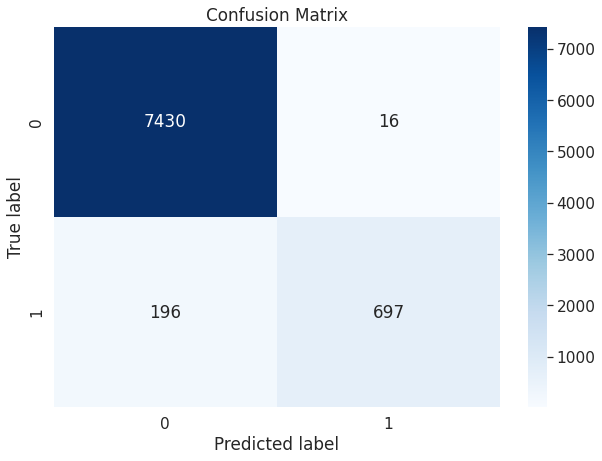

In [15]:
# create matrix
conf_mat = confusion_matrix(test['Actiware classification'], test['Predicted wake'])

# put matrix into data frame
df_cm = pd.DataFrame(conf_mat, range(2), range(2))

# plot matrix with blues color style
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) 

s = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
s.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')

s

### Metrics: Accuracy, Misclassification Rate, Precision, Recall, F1-score

#### Note: As we are trying to classify sleep, we consider 0 as the positive class

In [16]:
# Accuracy
acc = round(accuracy_score(test['Actiware classification'], test['Predicted wake'])*100, 2)
print("Accuracy score: \t", acc, '%')

# Misclassification Rate
print("Misclassification rate:\t", round(100-acc, 2), '%')

# Precision
print("Precision score:\t", 
      round(precision_score(test['Actiware classification'], test['Predicted wake'], pos_label=0)*100, 2), '%')
        
# Recall
print("Recall: \t\t", 
      round(recall_score(test['Actiware classification'], test['Predicted wake'], pos_label=0)*100, 2), '%')

# F1-Score
print("F1 score: \t\t", 
      round(f1_score(test['Actiware classification'], test['Predicted wake'], pos_label=0)*100, 2), '%')

Accuracy score: 	 97.46 %
Misclassification rate:	 2.54 %
Precision score:	 97.43 %
Recall: 		 99.79 %
F1 score: 		 98.59 %
